# 4. Feature Engineering

## TF-IDF, Sentiment score, text length, word count — included here for future flexibility

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
balanced_fakenews_df = pd.read_csv("../data/processed/balanced_fake_news_dataset.csv")

## 1. TF-IDF Vectorization

In [14]:
# TF-IDF with 1-2 grams, limit to top 5000 features
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_tfidf = tfidf.fit_transform(balanced_fakenews_df['processed_text'])


## 2. Sentiment Score

In [15]:
import numpy as np
sentiment_feature = balanced_fakenews_df['sentiment'].values.reshape(-1, 1)


## 3. Text-Based Features

In [16]:
balanced_fakenews_df['text_len'] = balanced_fakenews_df['processed_text'].apply(len)
balanced_fakenews_df['word_count'] = balanced_fakenews_df['processed_text'].apply(lambda x: len(str(x).split()))

# Normalize these features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
length_features = scaler.fit_transform(balanced_fakenews_df[['text_len', 'word_count']])


## 4. Combine All Features

In [17]:
from scipy.sparse import hstack

# Combine sparse matrix (TF-IDF) with dense features
X = hstack([X_tfidf, sentiment_feature, length_features])
y = balanced_fakenews_df['label'].values

print("Feature matrix shape:", X.shape)


Feature matrix shape: (62030, 10003)


### Test Train Split

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)


In [19]:
# Split X_tfidf separately for Naive Bayes
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

# 5. Train & Evaluate Models

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC()
}



In [21]:
for name, model in models.items():
    print(f"\n🔹 {name}")
    
    # Use TF-IDF only for Naive Bayes
    if name == "Naive Bayes":
        model.fit(X_train_tfidf, y_train)
        preds = model.predict(X_test_tfidf)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")


🔹 Logistic Regression
Accuracy: 0.8556 | F1 Score: 0.8556

🔹 Random Forest
Accuracy: 0.8606 | F1 Score: 0.8609

🔹 Naive Bayes
Accuracy: 0.8093 | F1 Score: 0.8000

🔹 SVM
Accuracy: 0.8655 | F1 Score: 0.8644


## 6. Confusion Matrix Plot

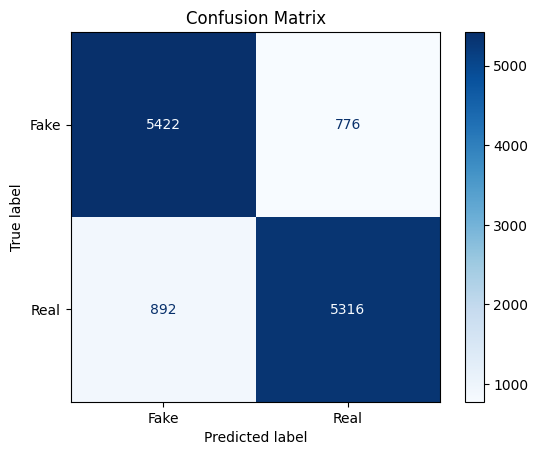

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming 'preds' from your best model
cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


⚠️ SVM does not support predict_proba. Skipping ROC.


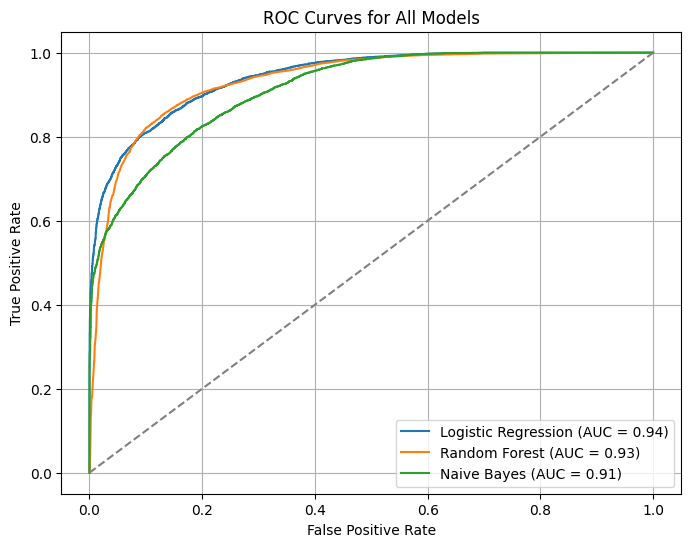

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for name, model in models.items():
    if name == "Naive Bayes":
        probs = model.predict_proba(X_test_tfidf)[:, 1]
    elif hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)[:, 1]
    else:
        print(f"⚠️ {name} does not support predict_proba. Skipping ROC.")
        continue

    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### SVM have the highest Accuracy and F1 score, so among classical model SVM performs the best. Saving SVM

In [ ]:
# # Save best model - SVM
# import joblib
# joblib.dump(models["SVM"], "../models/best_model_svm.joblib")


NameError: name 'models' is not defined